Epoch 1/5, Loss: 15.5447, Val Accuracy: 0.8941
Epoch 2/5, Loss: 5.8826, Val Accuracy: 0.9294
Epoch 3/5, Loss: 4.3182, Val Accuracy: 0.9529
Epoch 4/5, Loss: 5.1220, Val Accuracy: 0.9412
Epoch 5/5, Loss: 3.9687, Val Accuracy: 0.9529

Classification Report:
                  precision    recall  f1-score   support

       melanoma       0.96      0.98      0.97        65
vascular lesion       0.95      0.86      0.90        22

       accuracy                           0.95        87
      macro avg       0.95      0.92      0.94        87
   weighted avg       0.95      0.95      0.95        87

Confusion Matrix:
 [[64  1]
 [ 3 19]]
ROC AUC Score: 0.9839160839160839


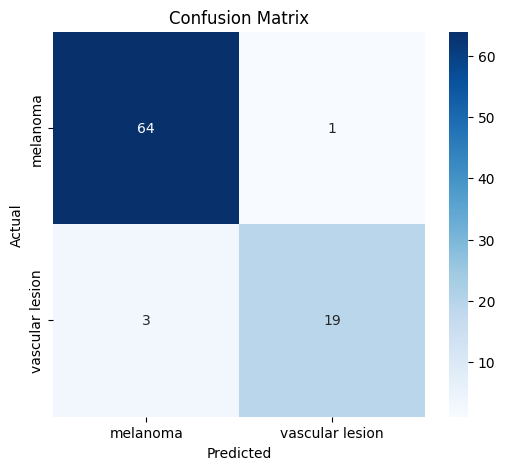

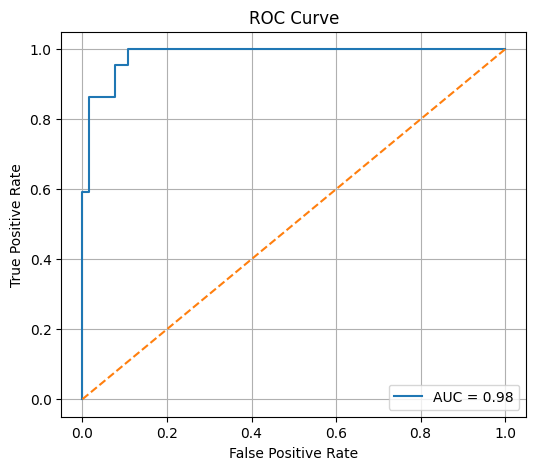

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


base_dir = '/content/Dataset_Final'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}


train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    model.train()
    return correct / total


def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_acc = evaluate_accuracy(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Val Accuracy: {val_acc:.4f}")


train(model, train_loader, val_loader, criterion, optimizer, epochs=5)


def evaluate(model, loader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = probs.argmax(1).cpu().numpy()
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

labels, preds, probs = evaluate(model, test_loader)


print("\nClassification Report:\n", classification_report(labels, preds, target_names=train_dataset.classes))
print("Confusion Matrix:\n", confusion_matrix(labels, preds))
print("ROC AUC Score:", roc_auc_score(labels, probs))


plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()
